In [1]:
import gym_blender
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

[2017-05-20 11:52:08,308] Making new env: ridge-v0


starting
UDP started
game over, total reward is  1


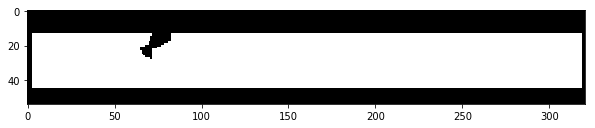

game over, total reward is  0


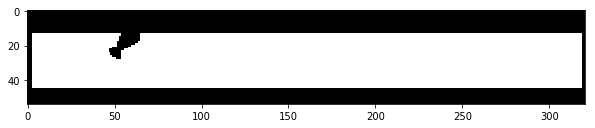

stopping


In [2]:
ble_env = gym.envs.make('ridge-v0')

for episode in range(2):
    total_reward = 0
    episode_over = 0
    
    ble_env._reset()
    
    while not episode_over:
        legal_action_set = ble_env.env.legal_action_set
        rand_action = np.random.choice(legal_action_set)
        ob, reward, episode_over, _ = ble_env._step(rand_action)

        total_reward += reward

        if episode_over:
            print "game over, total reward is ", total_reward
            plt.figure(figsize=(10,4))
            plt.imshow(ob, cmap=plt.cm.gray)
            plt.show() 

del ble_env